In [1]:
from ldp.agent import AgentConfig
from ldp.alg.rollout import RolloutManager
from fhda.data_analysis_env import DataAnalysisEnv
import os
import hashlib

import shutil
from pathlib import Path
import time
from pathlib import Path

from fhda.notebook_env import NBEnvironment
from fhda.utils import NBLanguage
from fhda import prompts
from ldp.data_structures import Trajectory, Transition


In [2]:
# ENVIRONMENT CONFIGURATION

# Set your API keys
os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
# If using docker, be sure to pull the image from docker hub first
# docker pull futurehouse/bixbench:aviary-notebook-env
# This image includes many bioinformatics and data science packages
os.environ["use_docker"] = "False"

def setup_data_analysis_env(query: str, dataset_folder: Path):   
    # Hash the task to get a unique identifier
    task_hash = hashlib.sha256(query.encode()).hexdigest()
    trajectory_path = Path("tmp_results_dir") / f"{task_hash}-{time.time()}"
    trajectory_path.mkdir(parents=True, exist_ok=True)
    nb_path = trajectory_path / NBEnvironment.NOTEBOOK_NAME
    # Copy task data to trajectory path
    for item in dataset_folder.iterdir():
        if item.is_file():
            shutil.copy2(item, trajectory_path)
        elif item.is_dir():
            shutil.copytree(
                item, trajectory_path / item.name, dirs_exist_ok=True
            )

    # Augment incoming task with CoT instructions
    augmented_task = f"""\
    Here is the user query to address:

    <query>
    {query}
    </query>

    {prompts.CHAIN_OF_THOUGHT_AGNOSTIC}
    {prompts.GENERAL_NOTEBOOK_GUIDELINES}"""

    # This can be R or PYTHON in Docker or with a local kernel if you have R installed
    language = NBLanguage.PYTHON  
    if language == NBLanguage.R:
        augmented_task += f"\n{prompts.R_OUTPUT_RECOMMENDATION_PROMPT}"

    dae = DataAnalysisEnv(
        problem_id=f"data-analysis-task-{task_hash}",
        problem=augmented_task,
        eval_mode=None,
        nb_path=nb_path,
        work_dir=trajectory_path,
        language=language,
        system_prompt=prompts.CAPSULE_SYSTEM_PROMPT_QUERY,
        use_tmp_work_dir=False,
    )
    return dae

In [3]:
# AVIARY ROLLOUT
# This folder only contains a single csv file on animal brain size and body mass from here:
# https://animaltraits.org/
# However, it could contain many files including nested folders
dataset_folder = Path("dataset")
query = "Analyze the dataset and give me an in depth analysis using pretty plots. I am particularly interested in crows."
environment = setup_data_analysis_env(query, dataset_folder)

agent = AgentConfig(
    agent_type="ReActAgent",
    agent_kwargs={
        "llm_model": {
            "model": "claude-3-5-sonnet-20241022", # any litellm supported model will work
            "parallel_tool_calls": False,
            "num_retries": 5,
            "temperature": 1.0,
        },
        "hide_old_env_states": True,
        "temperature": 0.0,
    },
)

agent = agent.construct_agent()
rollout = RolloutManager(agent=agent)

# You can see the notebook updating live in the tmp_results_dir folder
result = await rollout.sample_trajectories(environments=[environment], max_steps=10)

Timestep 0
Done: False
Agent Reasoning:
Observation: [Message(role='user', content="    Here is the user query to address:\n\n    <query>\n    Analyze the dataset and give me an in depth analysis using pretty plots. I am particularly interested in crows.\n    </query>\n\n    \nFollow these steps to create your notebook, using chain-of-thought reasoning at each stage:\n\n1. List Directory Contents:\n<analysis_planning>\n- Consider how to use the list_workdir tool to recursively list the directory contents.\n- Think about how to organize and present this information clearly in the notebook.\n- List potential challenges in interpreting the directory structure.\n- Consider how the directory structure might inform your approach to the analysis.\n</analysis_planning>\nPlace the output of the list_workdir tool inside <directory_contents> tags.\n\n2. Load Data and Perform Descriptive Statistics:\n<analysis_planning>\n- Identify which data files are most relevant to resolving the task. List the
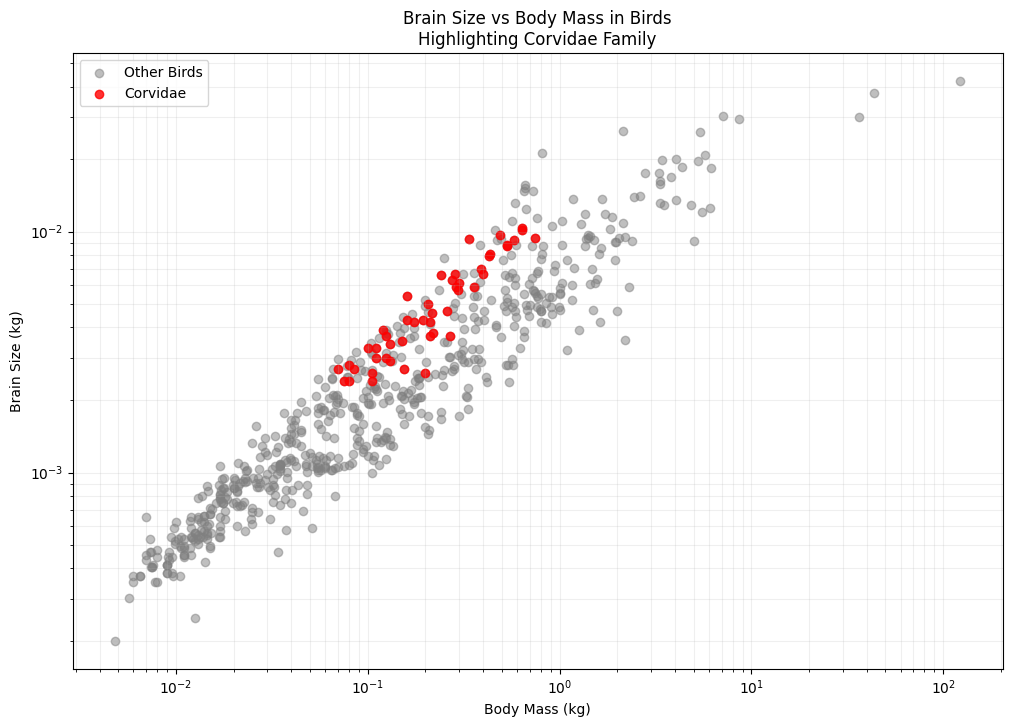
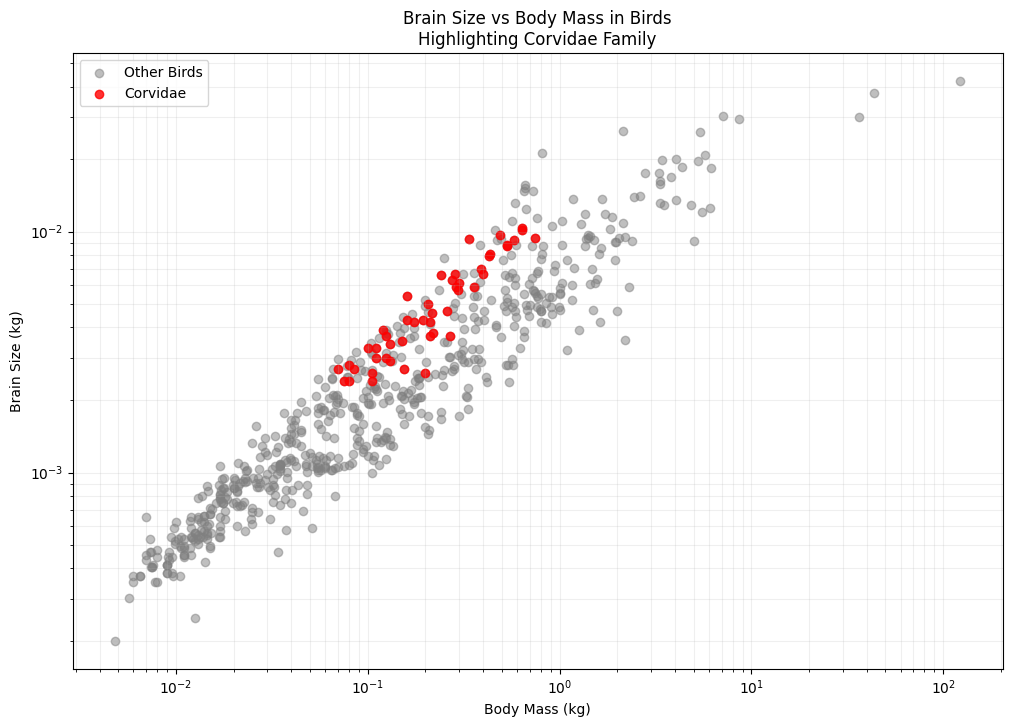
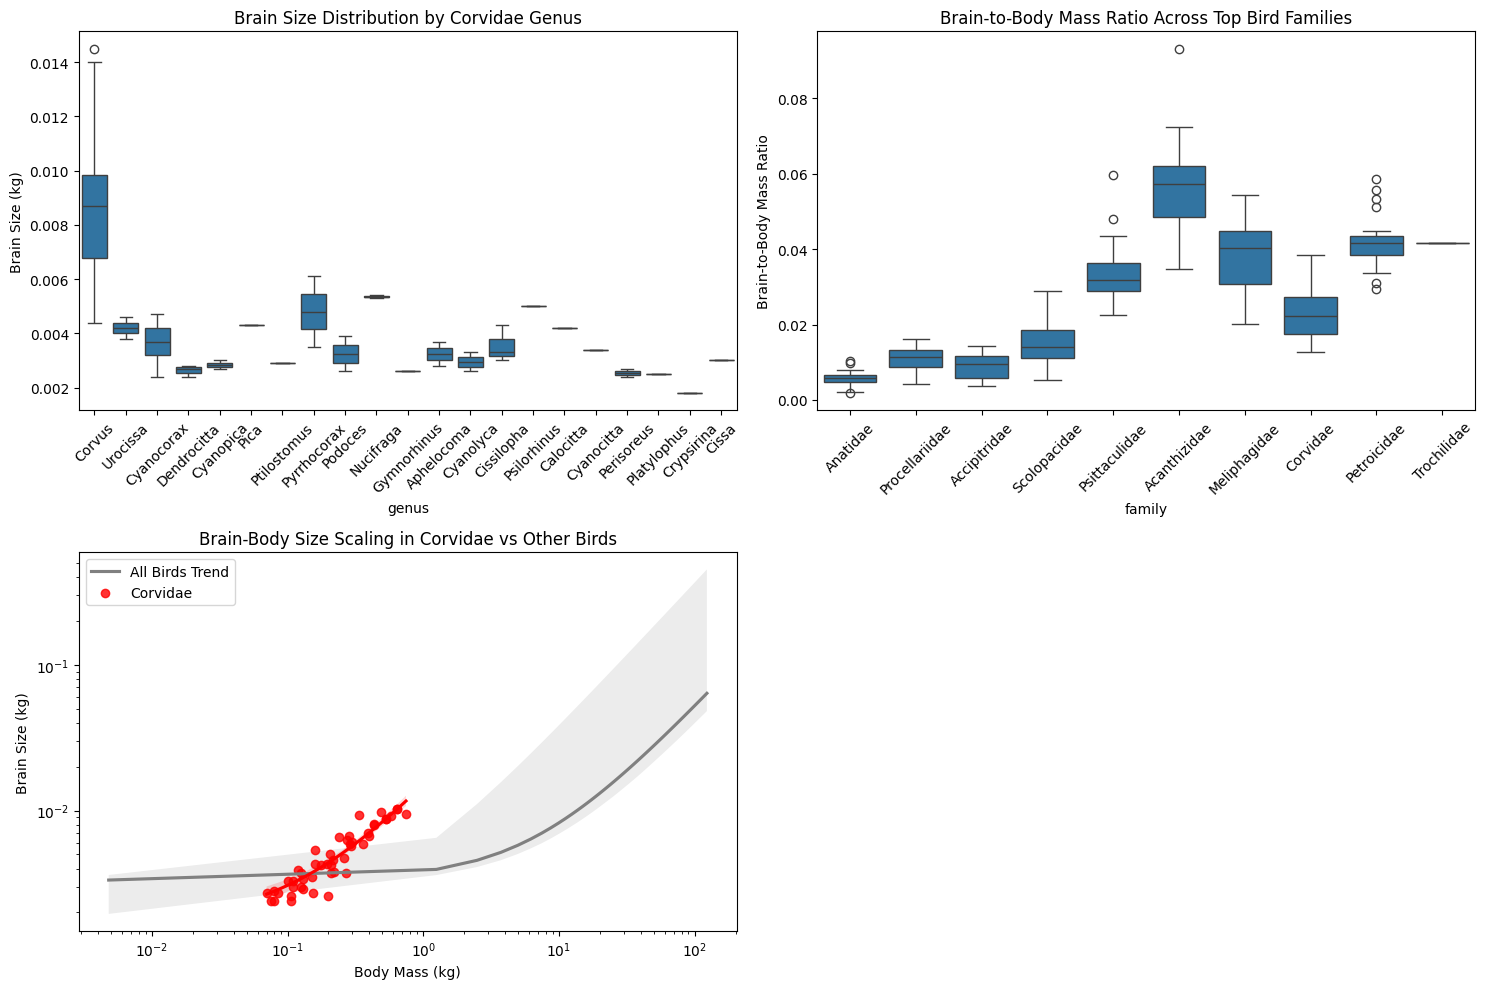

In [33]:
# INSPECT THE RESULT
trajectory = result[0]
# You can inspect each step in the trajectory and see what the agent's reasoning was,
# what tool it called, and what the observation was
for c,step in enumerate(trajectory.steps):
    print(f"Timestep {c}")
    print(f"Done: {step.done}")
    print("Agent Reasoning:")
    for message in step.agent_state.messages:
        if message.content:
            print(f"Message: {message.content[:200]} [Truncated]")
    print(f"Observation: {step.observation}")
    print(f"Action: {step.action.value}")
    print("---")

# You can also view the agent's final answer
print(environment.state.answer)

# Go to the notebook path to see the final notebook
print("\nGo to the notebook path to see the final notebook: \n", environment.nb_path)


In [5]:
# VANILLA ROLLOUT - this is a simple version of the what the rollout Manager does
dataset_folder = Path("dataset")
query = "Analyze the dataset and give me an in depth analysis using pretty plots. I am particularly interested in crows."
environment = setup_data_analysis_env(query, dataset_folder)

obs, tools = await environment.reset()
agent_state = await agent.init_state(tools)
trajectory = Trajectory()
max_steps = 10
for timestep in range(max_steps):
    action, next_agent_state, value = await agent.get_asv(agent_state, obs)
    next_obs, reward, done, trunc = await environment.step(action.value)
    # Create the transition object
    transition = Transition(
        timestep=timestep,
        agent_state=agent_state,
        next_agent_state=next_agent_state,
        observation=obs,
        next_observation=next_obs,
        action=action,
        reward=reward,
        done=done,
        truncated=trunc,
        value=value,
    )
    # Update steps by creating a new list with the additional transition
    trajectory.steps = [*trajectory.steps, transition]
    if done or trunc:
        break

    agent_state = next_agent_state
    obs = next_obs



Error executing cell 0:
Name: OSError
Value: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)
Traceback: ['\x1b---------------------------------------------------------------------------\x1b', '\x1bFileNotFoundError\x1b                         Traceback (most recent call last)', 'File \x1b~/Desktop/repos/aviary-internal/.venv/lib/python3.12/site-packages/matplotlib/style/core.py:129\x1b, in \x1buse\x1b(style)\x1b\n\x1b    128\x1b \x1btry\x1b:\n\x1b--> 129\x1b     style \x1b=\x1b \x1b_rc_params_in_file\x1b\x1b(\x1b\x1bstyle\x1b\x1b)\x1b\n\x1b    130\x1b \x1bexcept\x1b \x1bOSError\x1b \x1bas\x1b err:\n', 'File \x1b~/Desktop/repos/aviary-internal/.venv/lib/python3.12/site-packages/matplotlib/__init__.py:903\x1b, in \x1b_rc_params_in_file\x1b(fname, transform, fail_on_error)\x1b\n\x1b    902\x1b rc_temp \x1b=\x1b {}\n\x1b--> 903\x1b \x1bwith\x1b _open_file_or_url(fname) \x1bas\x1b fd:\n\x1b